In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

seed = 14
torch.manual_seed(seed)
np.random.seed(seed)

# Transformacja do tensora (niezbędna dla sieci)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Pobranie danych treningowych i testowych
train_dataset = torchvision.datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST("./data", train=False, download=True, transform=transform)

# Dataloadery
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Sprawdzenie kształtu danych
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self, out_channels=32, kernel_size=3, pool_size=2):
        super(CNNNetwork, self).__init__()
        
        # Sequential model - wszystkie warstwy w jednej strukturze
        self.model = nn.Sequential(
            # Warstwa konwolucyjna: wejście 1 kanał (grayscale), wyjście out_channels
            nn.Conv2d(in_channels=1, out_channels=out_channels, 
                     kernel_size=kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
            
            # Spłaszczenie
            nn.Flatten(),
            
            # Warstwa liniowa - LazyLinear automatycznie ustala wymiar wejściowy
            nn.LazyLinear(10)  # 10 klas w FashionMNIST
        )

    def forward(self, x):
        # x shape: [batch, 1, 28, 28]
        return self.model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [10]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)

            # Obliczenie błędu
            pred = model(X)
            loss = criterion(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
    return loss_history

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
    accuracy = correct / total
    return accuracy

--- Eksperyment 1: Liczba kanałów wyjściowych ---
Training CNN with 8 output channels...
Epoch 1/20, Loss: 0.4943
Epoch 2/20, Loss: 0.3514
Epoch 3/20, Loss: 0.3223
Epoch 4/20, Loss: 0.3023
Epoch 5/20, Loss: 0.2868
Epoch 6/20, Loss: 0.2776
Epoch 7/20, Loss: 0.2663
Epoch 8/20, Loss: 0.2588
Epoch 9/20, Loss: 0.2513
Epoch 10/20, Loss: 0.2473
Epoch 11/20, Loss: 0.2410
Epoch 12/20, Loss: 0.2377
Epoch 13/20, Loss: 0.2313
Epoch 14/20, Loss: 0.2278
Epoch 15/20, Loss: 0.2249
Epoch 16/20, Loss: 0.2197
Epoch 17/20, Loss: 0.2177
Epoch 18/20, Loss: 0.2143
Epoch 19/20, Loss: 0.2124
Epoch 20/20, Loss: 0.2099
8 channels Accuracy: 0.8908

Training CNN with 16 output channels...
Epoch 1/20, Loss: 0.4480
Epoch 2/20, Loss: 0.3149
Epoch 3/20, Loss: 0.2850
Epoch 4/20, Loss: 0.2657
Epoch 5/20, Loss: 0.2491
Epoch 6/20, Loss: 0.2385
Epoch 7/20, Loss: 0.2256
Epoch 8/20, Loss: 0.2185
Epoch 9/20, Loss: 0.2087
Epoch 10/20, Loss: 0.2032
Epoch 11/20, Loss: 0.1970
Epoch 12/20, Loss: 0.1901
Epoch 13/20, Loss: 0.1849
Ep

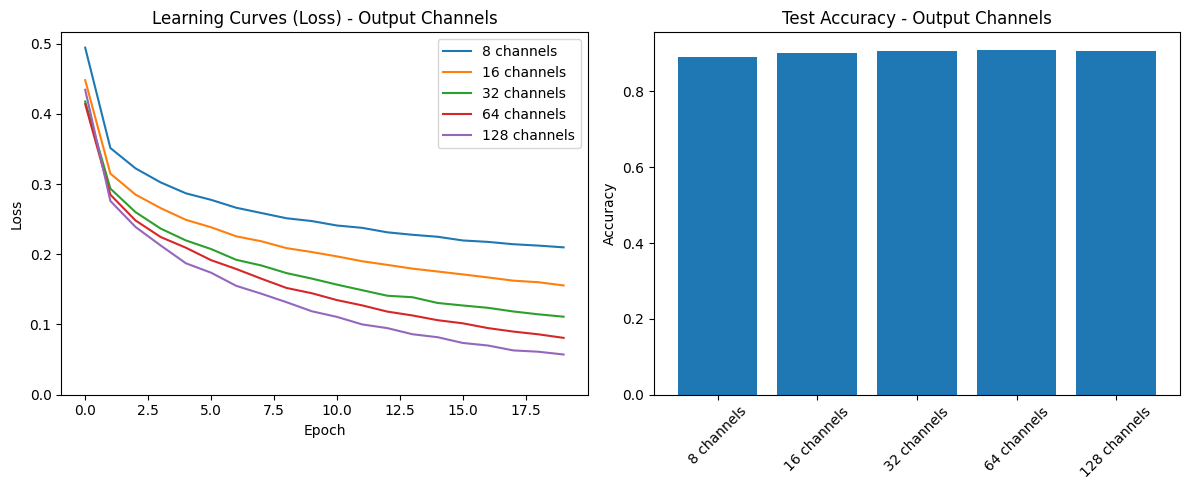

In [11]:
# Eksperyment 1: Liczba kanałów wyjściowych warstwy konwolucyjnej
out_channels_list = [8, 16, 32, 64, 128]
results_exp1 = {}

print("--- Eksperyment 1: Liczba kanałów wyjściowych ---")

for out_ch in out_channels_list:
    print(f"Training CNN with {out_ch} output channels...")
    model = CNNNetwork(out_channels=out_ch, kernel_size=3, pool_size=2).to(device)
    
    # Inicjalizacja LazyLinear poprzez wykonanie forward pass
    with torch.no_grad():
        dummy_input = torch.randn(1, 1, 28, 28).to(device)
        model(dummy_input)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_hist = train_model(model, train_loader, criterion, optimizer, epochs=20)
    acc = evaluate_model(model, test_loader)
    results_exp1[f'{out_ch} channels'] = {'loss': loss_hist, 'acc': acc}
    print(f"{out_ch} channels Accuracy: {acc:.4f}\n")

# Wizualizacja
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, res in results_exp1.items():
    plt.plot(res['loss'], label=name)
plt.title("Learning Curves (Loss) - Output Channels")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp1.keys())
accs = [results_exp1[n]['acc'] for n in names]
plt.bar(names, accs)
plt.title("Test Accuracy - Output Channels")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 1
*   **Mała liczba kanałów (8, 16)** może być niewystarczająca do wychwycenia wszystkich istotnych cech obrazów, co prowadzi do underfittingu.
*   **Zwiększanie liczby kanałów** (32, 64, 128) pozwala sieci nauczyć się bardziej złożonych i różnorodnych filtrów konwolucyjnych, co zazwyczaj poprawia dokładność.
*   **Zbyt duża liczba kanałów** może prowadzić do overfittingu i znacznie wydłuża czas obliczeń, zwiększając również liczbę parametrów modelu.
*   Optymalna liczba kanałów to kompromis między wydajnością a złożonością obliczeniową.


--- Eksperyment 2: Rozmiar filtra (kernel size) ---
Training CNN with kernel size 3x3...
Epoch 1/20, Loss: 0.4383
Epoch 2/20, Loss: 0.3060
Epoch 3/20, Loss: 0.2744
Epoch 4/20, Loss: 0.2488
Epoch 5/20, Loss: 0.2323
Epoch 6/20, Loss: 0.2169
Epoch 7/20, Loss: 0.2057
Epoch 8/20, Loss: 0.1939
Epoch 9/20, Loss: 0.1826
Epoch 10/20, Loss: 0.1743
Epoch 11/20, Loss: 0.1680
Epoch 12/20, Loss: 0.1582
Epoch 13/20, Loss: 0.1525
Epoch 14/20, Loss: 0.1497
Epoch 15/20, Loss: 0.1397
Epoch 16/20, Loss: 0.1360
Epoch 17/20, Loss: 0.1300
Epoch 18/20, Loss: 0.1268
Epoch 19/20, Loss: 0.1211
Epoch 20/20, Loss: 0.1172
Kernel 3x3 Accuracy: 0.9026

Training CNN with kernel size 5x5...
Epoch 1/20, Loss: 0.4100
Epoch 2/20, Loss: 0.2931
Epoch 3/20, Loss: 0.2586
Epoch 4/20, Loss: 0.2346
Epoch 5/20, Loss: 0.2190
Epoch 6/20, Loss: 0.2049
Epoch 7/20, Loss: 0.1887
Epoch 8/20, Loss: 0.1782
Epoch 9/20, Loss: 0.1669
Epoch 10/20, Loss: 0.1595
Epoch 11/20, Loss: 0.1511
Epoch 12/20, Loss: 0.1438
Epoch 13/20, Loss: 0.1359
Epoc

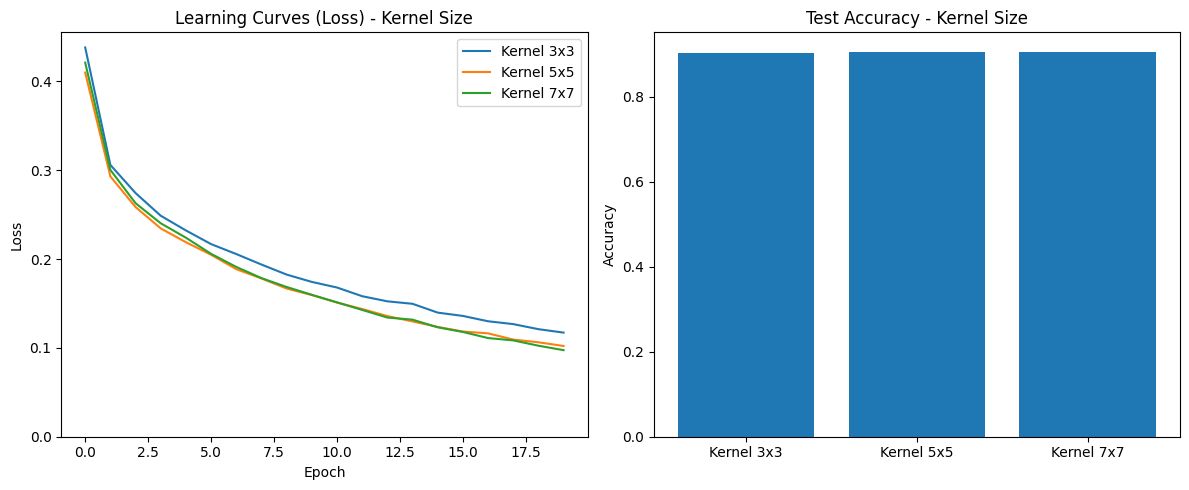

In [12]:
# Eksperyment 2: Rozmiar filtra warstwy konwolucyjnej
kernel_sizes = [3, 5, 7]
results_exp2 = {}
fixed_channels = 32

print("\n--- Eksperyment 2: Rozmiar filtra (kernel size) ---")

for k_size in kernel_sizes:
    print(f"Training CNN with kernel size {k_size}x{k_size}...")
    model = CNNNetwork(out_channels=fixed_channels, kernel_size=k_size, pool_size=2).to(device)
    
    # Inicjalizacja LazyLinear
    with torch.no_grad():
        dummy_input = torch.randn(1, 1, 28, 28).to(device)
        model(dummy_input)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_hist = train_model(model, train_loader, criterion, optimizer, epochs=20)
    acc = evaluate_model(model, test_loader)
    results_exp2[f'Kernel {k_size}x{k_size}'] = {'loss': loss_hist, 'acc': acc}
    print(f"Kernel {k_size}x{k_size} Accuracy: {acc:.4f}\n")

# Wizualizacja
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, res in results_exp2.items():
    plt.plot(res['loss'], label=name)
plt.title("Learning Curves (Loss) - Kernel Size")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp2.keys())
accs = [results_exp2[n]['acc'] for n in names]
plt.bar(names, accs)
plt.title("Test Accuracy - Kernel Size")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 2
*   **Mały kernel (3x3)** wychwytuje lokalne wzorce i jest najczęściej używany w praktyce ze względu na dobrą wydajność i mniejszą liczbę parametrów.
*   **Większe kernele (5x5, 7x7)** mogą wychwytywać bardziej globalne cechy obrazu, ale mają więcej parametrów i mogą być mniej efektywne.
*   W praktyce często stosuje się wiele warstw z małymi kernelami (np. dwie warstwy 3x3) zamiast jednej warstwy z dużym kernelem (np. 5x5), co daje większą nieliniowość przy mniejszej liczbie parametrów.
*   Dla małych obrazów (28x28) duże kernele mogą być mniej efektywne.


--- Eksperyment 3: Rozmiar okna poolingu ---
Training CNN with pool size 2x2...
Epoch 1/20, Loss: 0.4242
Epoch 2/20, Loss: 0.3013
Epoch 3/20, Loss: 0.2670
Epoch 4/20, Loss: 0.2474
Epoch 5/20, Loss: 0.2317
Epoch 6/20, Loss: 0.2170
Epoch 7/20, Loss: 0.2056
Epoch 8/20, Loss: 0.1948
Epoch 9/20, Loss: 0.1842
Epoch 10/20, Loss: 0.1750
Epoch 11/20, Loss: 0.1675
Epoch 12/20, Loss: 0.1607
Epoch 13/20, Loss: 0.1526
Epoch 14/20, Loss: 0.1475
Epoch 15/20, Loss: 0.1420
Epoch 16/20, Loss: 0.1353
Epoch 17/20, Loss: 0.1328
Epoch 18/20, Loss: 0.1264
Epoch 19/20, Loss: 0.1221
Epoch 20/20, Loss: 0.1176
Pool 2x2 Accuracy: 0.9083

Training CNN with pool size 3x3...
Epoch 1/20, Loss: 0.4326
Epoch 2/20, Loss: 0.3167
Epoch 3/20, Loss: 0.2872
Epoch 4/20, Loss: 0.2679
Epoch 5/20, Loss: 0.2536
Epoch 6/20, Loss: 0.2433
Epoch 7/20, Loss: 0.2340
Epoch 8/20, Loss: 0.2240
Epoch 9/20, Loss: 0.2180
Epoch 10/20, Loss: 0.2107
Epoch 11/20, Loss: 0.2036
Epoch 12/20, Loss: 0.1986
Epoch 13/20, Loss: 0.1952
Epoch 14/20, Loss

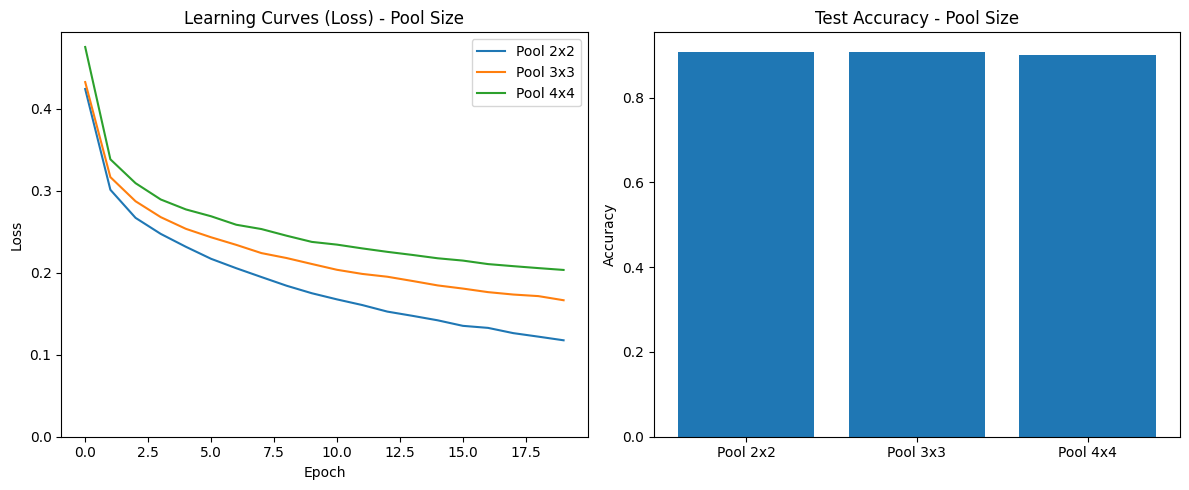

In [13]:
# Eksperyment 3: Rozmiar okna poolingu
pool_sizes = [2, 3, 4]
results_exp3 = {}
fixed_channels = 32
fixed_kernel = 3

print("\n--- Eksperyment 3: Rozmiar okna poolingu ---")

for p_size in pool_sizes:
    print(f"Training CNN with pool size {p_size}x{p_size}...")
    model = CNNNetwork(out_channels=fixed_channels, kernel_size=fixed_kernel, pool_size=p_size).to(device)
    
    # Inicjalizacja LazyLinear
    with torch.no_grad():
        dummy_input = torch.randn(1, 1, 28, 28).to(device)
        model(dummy_input)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_hist = train_model(model, train_loader, criterion, optimizer, epochs=20)
    acc = evaluate_model(model, test_loader)
    results_exp3[f'Pool {p_size}x{p_size}'] = {'loss': loss_hist, 'acc': acc}
    print(f"Pool {p_size}x{p_size} Accuracy: {acc:.4f}\n")

# Wizualizacja
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, res in results_exp3.items():
    plt.plot(res['loss'], label=name)
plt.title("Learning Curves (Loss) - Pool Size")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp3.keys())
accs = [results_exp3[n]['acc'] for n in names]
plt.bar(names, accs)
plt.title("Test Accuracy - Pool Size")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 3
*   **Max pooling** redukuje wymiary przestrzenne obrazu, zmniejszając liczbę parametrów i koszt obliczeniowy, a także wprowadza niezmienność translacyjną.
*   **Mały rozmiar poolingu (2x2)** jest najczęściej używany w praktyce - zachowuje więcej informacji przestrzennych przy jednoczesnej redukcji wymiarów.
*   **Większy rozmiar poolingu (3x3, 4x4)** bardziej redukuje wymiary, co może prowadzić do utraty ważnych informacji, szczególnie w małych obrazach (28x28).
*   Zbyt agresywny pooling może spowodować, że sieć straci zdolność do rozróżniania drobnych detali w obrazach.


--- Eksperyment 4: Odporność na szum ---
Scenario 1: Train Clean, Test Noisy
Epoch 1/20, Loss: 0.4152
Epoch 2/20, Loss: 0.2969
Epoch 3/20, Loss: 0.2624
Epoch 4/20, Loss: 0.2405
Epoch 5/20, Loss: 0.2241
Epoch 6/20, Loss: 0.2119
Epoch 7/20, Loss: 0.1992
Epoch 8/20, Loss: 0.1881
Epoch 9/20, Loss: 0.1782
Epoch 10/20, Loss: 0.1691
Epoch 11/20, Loss: 0.1625
Epoch 12/20, Loss: 0.1566
Epoch 13/20, Loss: 0.1499
Epoch 14/20, Loss: 0.1428
Epoch 15/20, Loss: 0.1381
Epoch 16/20, Loss: 0.1338
Epoch 17/20, Loss: 0.1279
Epoch 18/20, Loss: 0.1241
Epoch 19/20, Loss: 0.1200
Epoch 20/20, Loss: 0.1166
Train Clean, Test Noisy Accuracy: 0.2129

Scenario 2: Train Noisy, Test Noisy
Epoch 1/20, Loss: 0.5412
Epoch 2/20, Loss: 0.4324
Epoch 3/20, Loss: 0.4078
Epoch 4/20, Loss: 0.3964
Epoch 5/20, Loss: 0.3876
Epoch 6/20, Loss: 0.3825
Epoch 7/20, Loss: 0.3753
Epoch 8/20, Loss: 0.3731
Epoch 9/20, Loss: 0.3688
Epoch 10/20, Loss: 0.3665
Epoch 11/20, Loss: 0.3617
Epoch 12/20, Loss: 0.3617
Epoch 13/20, Loss: 0.3582
Epoc

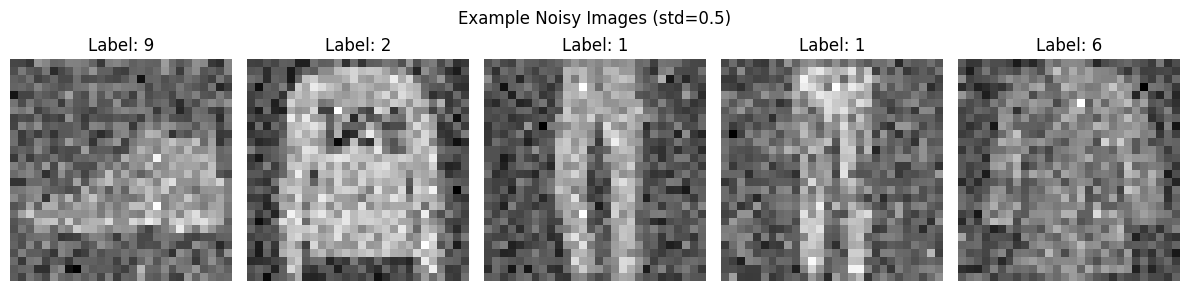

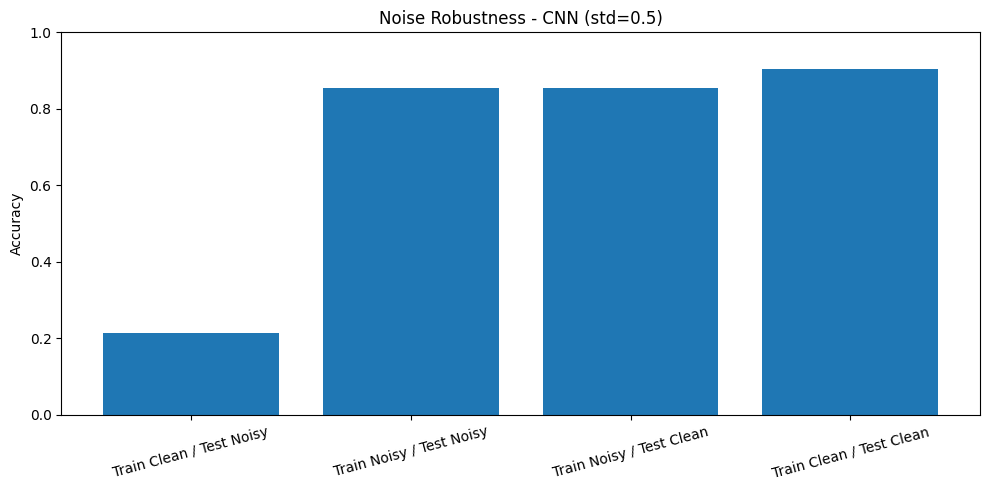

In [14]:
# Eksperyment 4: Zaburzenia danych (Szum Gaussowski)
noise_std = 0.5
results_exp4 = {}

print("\n--- Eksperyment 4: Odporność na szum ---")

# Transformacja z szumem
transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * noise_std)
])

# Dataset z szumem
train_dataset_noisy = torchvision.datasets.FashionMNIST("./data", train=True, download=True, transform=transform_noisy)
test_dataset_noisy = torchvision.datasets.FashionMNIST("./data", train=False, download=True, transform=transform_noisy)

train_loader_noisy = torch.utils.data.DataLoader(train_dataset_noisy, batch_size=64, shuffle=True)
test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

# Scenariusz 1: Trening na czystych danych, test na zaszumionych
print("Scenario 1: Train Clean, Test Noisy")
model_clean = CNNNetwork(out_channels=32, kernel_size=3, pool_size=2).to(device)

# Inicjalizacja LazyLinear
with torch.no_grad():
    dummy_input = torch.randn(1, 1, 28, 28).to(device)
    model_clean(dummy_input)

optimizer = optim.Adam(model_clean.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Trenujemy na standardowym train_loader (czyste dane)
train_model(model_clean, train_loader, criterion, optimizer, epochs=20) 
acc_clean_noisy = evaluate_model(model_clean, test_loader_noisy) # Testujemy na zaszumionych
print(f"Train Clean, Test Noisy Accuracy: {acc_clean_noisy:.4f}\n")
results_exp4['Train Clean / Test Noisy'] = acc_clean_noisy

# Scenariusz 2: Trening na zaszumionych danych, test na zaszumionych
print("Scenario 2: Train Noisy, Test Noisy")
model_noisy = CNNNetwork(out_channels=32, kernel_size=3, pool_size=2).to(device)

# Inicjalizacja LazyLinear
with torch.no_grad():
    dummy_input = torch.randn(1, 1, 28, 28).to(device)
    model_noisy(dummy_input)

optimizer = optim.Adam(model_noisy.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Trenujemy na train_loader_noisy
train_model(model_noisy, train_loader_noisy, criterion, optimizer, epochs=20) 
acc_noisy_noisy = evaluate_model(model_noisy, test_loader_noisy) # Testujemy na zaszumionych
print(f"Train Noisy, Test Noisy Accuracy: {acc_noisy_noisy:.4f}\n")
results_exp4['Train Noisy / Test Noisy'] = acc_noisy_noisy

# Scenariusz 3: Trening na zaszumionych danych, test na czystych
print("Scenario 3: Train Noisy, Test Clean")
acc_noisy_clean = evaluate_model(model_noisy, test_loader) # Testujemy na czystych (model_noisy już wytrenowany)
print(f"Train Noisy, Test Clean Accuracy: {acc_noisy_clean:.4f}")
results_exp4['Train Noisy / Test Clean'] = acc_noisy_clean

# Baseline: Train Clean, Test Clean (dla odniesienia)
acc_clean_clean = evaluate_model(model_clean, test_loader)
results_exp4['Train Clean / Test Clean'] = acc_clean_clean

# Wizualizacja przykładowych zaszumionych obrazów
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i, (img, label) in enumerate(test_dataset_noisy):
    if i >= 5:
        break
    axes[i].imshow(img.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.suptitle(f'Example Noisy Images (std={noise_std})')
plt.tight_layout()
plt.show()

# Wizualizacja wyników
plt.figure(figsize=(10, 5))
plt.bar(results_exp4.keys(), results_exp4.values())
plt.title(f"Noise Robustness - CNN (std={noise_std})")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 4
*   **Train Clean / Test Noisy**: CNN trenowany na czystych danych ma trudności z klasyfikacją zaszumionych obrazów, pokazując brak generalizacji na dane spoza rozkładu treningowego.
*   **Train Noisy / Test Noisy**: Trenowanie na zaszumionych danych znacząco poprawia odporność na szum - sieć uczy się ignorować szum i skupiać na istotnych cechach obrazu.
*   **Train Noisy / Test Clean**: Model trenowany na danych z szumem często radzi sobie całkiem dobrze na czystych danych, ponieważ szum działa jak forma augmentacji danych i regularyzacji.
*   **CNN vs Fully Connected**: Sieci konwolucyjne są naturalnie bardziej odporne na szum niż sieci w pełni połączone, ponieważ lokalne filtry konwolucyjne mogą lepiej wychwytywać niezmienne cechy obrazu mimo obecności szumu.
*   Data augmentation poprzez dodawanie szumu w treningu to skuteczna technika zwiększania odporności modelu.